In [1]:
import os
from pydap.client import open_url
import xarray as xr
import datetime
from datetime import timedelta, date
import netCDF4 as nc
from netCDF4 import Dataset
import os
import sys
sys.path.append(os.path.abspath(".."))
from utils.degree_day_equations import *
from utils.net_cdf_functions import *
from utils.processing_functions import *
#from utils.visualization_functions import *

import pandas as pd
#from visualization_functions import *
import numpy as np
data_path =  "../data/"

In [2]:
import dask as dask
import dask.array as da

#dask instance
from dask.distributed import Client
client = Client(n_workers=8, threads_per_worker=1, memory_limit='2GB')
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58708,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:58752,Total threads: 1
Dashboard: http://127.0.0.1:58757/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:58711,


In [3]:
#turn bbox into a dict of lat and lon with lat_min long_max etc 36.405810,-119.855347,36.710265,-119.200287
def bbox_to_dict(bbox):
    bbox = bbox.split(",")
    bbox_dict = {}
    bbox_dict["lat_min"] = float(bbox[0])
    bbox_dict["lon_min"] = float(bbox[1])
    bbox_dict["lat_max"] = float(bbox[2])
    bbox_dict["lon_max"] = float(bbox[3])
    return bbox_dict

bbox = "36.405810,-119.855347,36.710265,-119.200287"
bbox_dict = bbox_to_dict(bbox)
LTT = 9.4
UTT = 999
'''
data = testing_load_data(data_path , "2000-01-01", lat = 36.558188, lon = -119.527130, LTT = 9.4, UTT = 999, window = 2 )
data.to_netcdf("../data/temp/orange_grvove_test.nc")
'''
#load data
combined_dd_data = xr.open_dataset("../data/temp/orange_grvove_test.nc")
mod_1_dd_data = combined_dd_data
mod_1_dd_data['day_of_year'] = mod_1_dd_data.indexes['t'].dayofyear
mod_1_dd_data = mod_1_dd_data.set_coords('day_of_year')
mod_1_data = mod_1_dd_data.groupby('day_of_year').mean('t')
mod_1_data_dd = mod_1_data['degree_days'].values


In [ ]:


def fflies_model_1(data, start, threshold):
    #start is the index of the first day of the year
    #initialize variables
    cumsum = 0
    elapsed_days = 0
    #iterate through the data array starting from the given start position
    for i in range(start, len(data)):
        #add the value of the current position to the cumsum
        cumsum += data[i]
        #increment the elapsed days
        elapsed_days += 1
        #if the cumsum is greater than or equal to the threshold, return the number of elapsed days
        if cumsum >= threshold:
            return elapsed_days
    #if the end of the array is reached, start over from the beginning and keep counting
    for i in range(0, start):
        cumsum += data[i]
        elapsed_days += 1
        if cumsum >= threshold:
            return elapsed_days
    return elapsed_days
# Loop through each fly species

<xarray.Dataset> Size: 27MB
Dimensions:      (day_of_year: 366, latitude: 96, longitude: 96)
Coordinates:
  * longitude    (longitude) float64 768B -121.5 -121.5 -121.4 ... -117.6 -117.5
  * latitude     (latitude) float64 768B 38.54 38.5 38.46 ... 34.67 34.62 34.58
  * day_of_year  (day_of_year) int32 1kB 1 2 3 4 5 6 ... 361 362 363 364 365 366
Data variables:
    degree_days  (day_of_year, latitude, longitude) float64 27MB 1.117 ... 1.154

In [ ]:
def fflies_model_run_wrapper(date, data, dd_threshold, use_current_years_weather):
    # Assuming data is a single point (1x1xn) xarray DataArray
    return fflies_model_run(date, data, dd_threshold, use_current_years_weather)

def apply_fflies_model_run( data, date, dd_threshold=754):
    # Apply the wrapper function over the x and y dimensions
    result = xr.apply_ufunc(
        fflies_model_1,
       
        data,
        date,
        dd_threshold,
        input_core_dims=[[], [], []],
        output_core_dims=[[]],
        vectorize=True,
        #dask='parallelized',
        output_dtypes=[]
    )
    return result


In [27]:
latitude = 36.631151
longitude = -119.338321
window_size = 6

# Find the indices of the given point
lat_idx = results_da.latitude.sel(latitude=latitude, method='nearest').item()
lon_idx = results_da.longitude.sel(longitude=longitude, method='nearest').item()

# Find the index positions
lat_pos = results_da.latitude.values.tolist().index(lat_idx)
lon_pos = results_da.longitude.values.tolist().index(lon_idx)

# Select a window of pixels around those indices
subset_da = results_da.isel(
    latitude=slice(lat_pos - window_size, lat_pos + window_size + 1),
    longitude=slice(lon_pos - window_size, lon_pos + window_size + 1)
)


In [9]:
result = apply_fflies_model_run( mod_1_data, 10, dd_threshold=754)

TypeError: object of type 'float' has no len()

In [ ]:
def fflies_model_1(data, start, threshold):
    # Ensure data is an xarray DataArray
    if isinstance(data, np.ndarray):
        data = xr.DataArray(data)
    
    # Initialize cumulative sum and elapsed days
    cumsum = 0
    elapsed_days = 0
    
    # Iterate through the data array starting from the given start position
    for i in range(start, len(data)):
        # Add the value of the current position to the cumsum
        cumsum += data[i]
        # Increment the elapsed days
        elapsed_days += 1
        # If the cumsum is greater than or equal to the threshold, return the number of elapsed days
        if cumsum >= threshold:
            return elapsed_days
    
    # If the end of the array is reached, start over from the beginning and keep counting
    for i in range(0, start):
        cumsum += data[i]
        elapsed_days += 1
        if cumsum >= threshold:
            return elapsed_days
    
    # If the threshold is not reached, return the total number of days
    return elapsed_days

def apply_fflies_model_run(data, date, dd_threshold=754):
    # Apply the wrapper function over the x and y dimensions
    result = xr.apply_ufunc(
        fflies_model_1,
        data,
        date,
        dd_threshold,
        input_core_dims=[['day_of_year'], [], []],
        output_core_dims=[[]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[int]
    )
    return result

# Example usage


results = []

# Loop through each date from 1 to 365
for date in range(1, 366):
    print(date)
    result = apply_fflies_model_run(mod_1_data_chunked, date, dd_threshold=754)
    results.append(result)

# Combine the results into an xarray DataArray
results_da = xr.concat(results, dim='start_day_of_year')
results_da['start_day_of_year'] = np.arange(1, 366)

# Save the DataArray as a NetCDF file


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [2]:
combined_dd_data = xr.open_dataset("../data/temp/orange_grvove_test.nc")
combined_dd_data

<xarray.Dataset> Size: 668MB
Dimensions:      (t: 9064, longitude: 96, latitude: 96)
Coordinates:
  * t            (t) datetime64[ns] 73kB 2000-01-01 2000-01-02 ... 2024-10-24
  * longitude    (longitude) float64 768B -121.5 -121.5 -121.4 ... -117.6 -117.5
  * latitude     (latitude) float64 768B 38.54 38.5 38.46 ... 34.67 34.62 34.58
Data variables:
    degree_days  (t, latitude, longitude) float64 668MB ...

In [ ]:
#combined dd data for first t index and all lat and lon


<xarray.DataArray 't' ()> Size: 8B
array('2000-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    t        datetime64[ns] 8B 2000-01-01
Attributes:
    _CoordinateAxisType:  Time
    _ChunkSizes:          512

In [3]:
def fflies_model_1(data, start, threshold):
    # Ensure data is an xarray DataArray
    if isinstance(data, np.ndarray):
        data = xr.DataArray(data)
    
    # Initialize cumulative sum and elapsed days
    cumsum = 0
    elapsed_days = 0
    
    # Iterate through the data array starting from the given start position
    for i in range(start, len(data)):
        # Add the value of the current position to the cumsum
        cumsum += data[i]
        # Increment the elapsed days
        elapsed_days += 1
        # If the cumsum is greater than or equal to the threshold, return the number of elapsed days
        if cumsum >= threshold:
            return elapsed_days
    
    # If the end of the array is reached, start over from the beginning and keep counting
    for i in range(0, start):
        cumsum += data[i]
        elapsed_days += 1
        if cumsum >= threshold:
            return elapsed_days
    
    # If the threshold is not reached, return the total number of days
    return elapsed_days

def apply_fflies_model_run(data, date, dd_threshold=754):
    # Apply the wrapper function over the x and y dimensions
    result = xr.apply_ufunc(
        fflies_model_1,
        data,
        date,
        dd_threshold,
        input_core_dims=[['t'], [], []],
        output_core_dims=[[]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[int]
    )
    return result

# Example usage

combined_dd_data = xr.open_dataset("../data/temp/orange_grvove_test.nc")
combined_dd_data_chunked = combined_dd_data.chunk({'latitude': 10, 'longitude': 10})
results = []
import datetime
from datetime import timedelta

# Loop through each date from 1 to 365

#I think here instead of using a datetime as an indexer, I want to use the index position of that date in the data array - maybe a dict of the two?
for year in range(2000, 2001):
    for day_of_year in range(1, 2):
        start_day = datetime.datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
        time_index = np.argwhere(combined_dd_data_chunked.t.values == np.datetime64(start_day)).flatten()[0]
        print(time_index)
        result = apply_fflies_model_run(combined_dd_data_chunked, time_index, dd_threshold=754)
        results.append(result)

# Combine the results into an xarray DataArray
results_da = xr.concat(results, dim='t')
results_da['start_day_of_year'] = np.arange(1, 366)

# Save the DataArray as a NetCDF file
results_da = results_da.compute()
#results_da.to_netcdf("../data/temp/orange_grvove_test_m2.nc")


0


In [4]:
results_da

<xarray.Dataset> Size: 40kB
Dimensions:            (t: 1, latitude: 96, longitude: 96,
                        start_day_of_year: 365)
Coordinates:
  * longitude          (longitude) float64 768B -121.5 -121.5 ... -117.6 -117.5
  * latitude           (latitude) float64 768B 38.54 38.5 38.46 ... 34.62 34.58
  * start_day_of_year  (start_day_of_year) int32 1kB 1 2 3 4 ... 362 363 364 365
Dimensions without coordinates: t
Data variables:
    degree_days        (t, latitude, longitude) int32 37kB 156 156 ... 149 149

In [8]:
combined_dd_data_chunked.isel(t = 1)

<xarray.Dataset> Size: 75kB
Dimensions:      (longitude: 96, latitude: 96)
Coordinates:
    t            datetime64[ns] 8B 2000-01-02
  * longitude    (longitude) float64 768B -121.5 -121.5 -121.4 ... -117.6 -117.5
  * latitude     (latitude) float64 768B 38.54 38.5 38.46 ... 34.67 34.62 34.58
Data variables:
    degree_days  (latitude, longitude) float64 74kB dask.array<chunksize=(10, 10), meta=np.ndarray>

In [13]:
results_da = results_da.compute()

c:\Users\Thomas.Worm\AppData\Local\anaconda3\envs\fruitflypheno\Lib\site-packages\distributed\client.py:3361: UserWarning: Sending large graph of size 33.72 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [3]:
import datetime
from datetime import timedelta

# Loop through each date from 1 to 365
for year in range(2000, 2001):
    for day_of_year in range(1, 3):
        start_day = datetime.datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
        print(start_day)
        result = apply_fflies_model_run(combined_dd_data_chunked, start_day, dd_threshold=754)
        results.append(result)
results_da = xr.concat(results, dim='start_day_of_year')

results_test = results.compute()

2000-01-01 00:00:00


NameError: name 'combined_dd_data_chunked' is not defined

In [31]:
import xarray as xr
import hvplot.xarray
latitude = 36.631151
longitude = -119.338321
window_size = 20

# Find the indices of the given point
lat_idx = results_da.latitude.sel(latitude=latitude, method='nearest').item()
lon_idx = results_da.longitude.sel(longitude=longitude, method='nearest').item()

# Find the index positions
lat_pos = results_da.latitude.values.tolist().index(lat_idx)
lon_pos = results_da.longitude.values.tolist().index(lon_idx)

# Select a window of pixels around those indices
subset_da = results_da.isel(
    latitude=slice(lat_pos - window_size, lat_pos + window_size + 1),
    longitude=slice(lon_pos - window_size, lon_pos + window_size + 1)
)

# Assuming results_da is already defined and contains the results
# Example: results_da = xr.open_dataset("results.nc")['your_variable']
results_da_array = subset_da['degree_days']
# Visualize the DataArray with a map and a slider for start_day_of_year
plot = results_da_array.hvplot.quadmesh(
    x='longitude', y='latitude', z='degree_days',  # Adjust 'values' to the actual variable name in results_da
    geo=True, tiles='OSM', frame_width=800, frame_height=600,
    clim=(results_da_array.min(), results_da_array.max()),  # Set color limits
    title='Degree Days Accumulation',
    groupby='start_day_of_year',  # Slider for start_day_of_year
    cmap='viridis'  # Choose a colormap
)

# Display the plot
hvplot.show(plot)

Launching server at http://localhost:53397


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
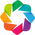

Launching server at http://localhost:64942


In [ ]:
import panel as pn
import numpy as np
import holoviews as hv
hv.extension('bokeh')
#results_da = results_da.rename({'degree_days': 'duration_to_f3'})

# Define the coordinates and the window size
latitude = 36.631151
longitude = -119.338321
window_size = 10

# Find the indices of the given point
lat_idx = results_da.latitude.sel(latitude=latitude, method='nearest').item()
lon_idx = results_da.longitude.sel(longitude=longitude, method='nearest').item()

# Find the index positions
lat_pos = results_da.latitude.values.tolist().index(lat_idx)
lon_pos = results_da.longitude.values.tolist().index(lon_idx)

# Select a window of pixels around those indices
subset_da = results_da.isel(
    latitude=slice(lat_pos - window_size, lat_pos + window_size + 1),
    longitude=slice(lon_pos - window_size, lon_pos + window_size + 1)
)
subset_da_array = subset_da['duration_to_f3']
alpha_slider = pn.widgets.FloatSlider(name='Transparency', start=0, end=1, step=0.1, value=0.7)

# Create the interactive plot
plot = subset_da_array.hvplot.quadmesh(
    x='longitude', y='latitude', z='duration_to_f3',  # Adjust 'duration_to_f3' to the actual variable name in results_da
    geo=True, tiles='OSM', frame_width=800, frame_height=600,
    clim=(subset_da_array.min(), subset_da_array.max()),  # Set color limits
    title='Duration to F3 Accumulation',
    groupby='start_day_of_year',  # Slider for start_day_of_year
    cmap='viridis',  # Choose a colormap
    alpha=alpha_slider.value  # Default transparency
)

# Create a histogram of the plotted values
def create_histogram(subset_da_array, start_day_of_year):
    return subset_da.sel(start_day_of_year=start_day_of_year).hvplot.hist(y='duration_to_f3', bins=50, alpha=0.7)

# Create a dynamic map and histogram
def update_histogram(start_day_of_year):
    return create_histogram(subset_da, start_day_of_year)

# Create a DynamicMap for the histogram
histogram_dmap = hv.DynamicMap(update_histogram, streams=[hv.streams.Stream.define('start_day_of_year', start_day_of_year=1)()])

# Update the transparency of the plot
def update_alpha(event):
    plot.opts(alpha=event.new)

alpha_slider.param.watch(update_alpha, 'value')

# Create a layout with the plot, histogram, and transparency slider
layout = pn.Column(
    pn.Row(plot, pn.Column(histogram_dmap)),
    alpha_slider
)

# Save the layout as an HTML file
pn.panel(layout).save('interactive_plot_mod1.html', embed=True)

# Display the layout
pn.serve(layout)

In [10]:
mod_1_data

<xarray.Dataset> Size: 27MB
Dimensions:      (day_of_year: 366, latitude: 96, longitude: 96)
Coordinates:
  * longitude    (longitude) float64 768B -121.5 -121.5 -121.4 ... -117.6 -117.5
  * latitude     (latitude) float64 768B 38.54 38.5 38.46 ... 34.67 34.62 34.58
  * day_of_year  (day_of_year) int32 1kB 1 2 3 4 5 6 ... 361 362 363 364 365 366
Data variables:
    degree_days  (day_of_year, latitude, longitude) float64 27MB 1.117 ... 1.154

In [9]:
import xarray as xr
from glob import glob

def read_netcdfs(files, coords, LTT, UTT):
    def process_one_path(path):
        # Use a context manager to ensure the file gets closed after use
        with xr.open_dataset(path) as ds:
            # Initialize an empty list to store data for each point or bounding box
            point_datasets = []
            
            if isinstance(coords, tuple) and len(coords) == 2:
                # Single point case
                lat, lon = coords
                ds_point = ds.sel(latitude=lat, longitude=lon, method="nearest")
                ds_point["degree_days"] = single_sine_horizontal_cutoff(
                    ds_point["tmin"], ds_point["tmax"], LTT, UTT
                )
                ds_point = ds_point.drop_vars(["tmin", "tmax"])
                ds_point.load()
                point_datasets.append(ds_point)
            elif isinstance(coords, dict) and all(k in coords for k in ["lat_min", "lat_max", "lon_min", "lon_max"]):
                # Bounding box case
                lat_min, lat_max = coords["lat_min"], coords["lat_max"]
                lon_min, lon_max = coords["lon_min"], coords["lon_max"]
                ds_bbox = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
                ds_bbox["degree_days"] = single_sine_horizontal_cutoff(
                    ds_bbox["tmin"], ds_bbox["tmax"], LTT, UTT
                )
                ds_bbox = ds_bbox.drop_vars(["tmin", "tmax"])
                ds_bbox.load()
                point_datasets.append(ds_bbox)
            else:
                raise ValueError("Invalid coordinates format. Provide a tuple for a single point or a dictionary for a bounding box.")
            
            # Concatenate data for all points or bounding boxes along a new dimension 'point'
            ds_combined = xr.concat(point_datasets, dim="point")
            return ds_combined

    # Get a sorted list of file paths
    paths = sorted(glob(files))
    # Process each file and store the datasets in a list
    datasets = [process_one_path(p) for p in paths]
    # Concatenate all datasets along the specified dimension
    combined = xr.concat(datasets, "t")
    return combined

In [10]:
data = read_netcdfs( files=data_path + "PRISM/*/PRISM_temp_*.nc", coords = bbox_dict , LTT= LTT, UTT=UTT)

In [11]:
data

<xarray.Dataset> Size: 145kB
Dimensions:      (t: 9064, point: 1, longitude: 16, latitude: 0)
Coordinates:
  * t            (t) datetime64[ns] 73kB 2000-01-01 2000-01-02 ... 2024-10-24
  * longitude    (longitude) float64 128B -119.8 -119.8 -119.7 ... -119.2 -119.2
  * latitude     (latitude) float64 0B 
Dimensions without coordinates: point
Data variables:
    degree_days  (t, point) object 73kB None None None None ... None None None
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t